- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
    - [10-fold-cross-validation](#10-fold-cross-validation)
    - [#Hyperparameters](#Hyperparameters)
- [Visualization](#Visualization)
    - [Interpretation](#Interpretation)
- [Implemented-but-not-used](#Implemented-but-not-used)
    - [Debug](#Debug)
    
    
 set|  max word-stroke length| avg word-stroke length | max drawing-stroke length
--|--|--|--
training set (0+1)|289|14|**1046**
validation set (2)|233| ?|618
test set (3) |218|?|423

trim data at 1050 which has a lot more divisors than 1046 so it's more convenient in regards to pooling

In [1]:
#smart manuscript
from smartmanuscript.corpus_iam import _import_set

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})#for prettier plots
#math tools
import numpy as np
#preprocessing
from sklearn.preprocessing import scale
#machine learning
import torch
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("using",device,"device")
#io
from os.path import join
from os.path import exists
from os import makedirs
from os import listdir
import pickle
import sys
sys.path.append("..")
#utils
from time import time
import warnings
#custom
from parkinson_detection.modules.utils import *
#models
from parkinson_detection.modules.CNN1d import CNN1d

using cuda device


# Utils

In [16]:
def plot(plot_i,train,valid,test):
    plt.title(model_name)
    plt.plot(train,label="training")
    if valid is not None:
        plt.plot(valid,label="validation")
    plt.plot(test,label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()
    if plot_i!=0:
        plt.ylim(0,1)

def scale_data(data):
    for i,stroke in enumerate(data):
        #removes t0 from each timestamps so the time stamp measure represents the length of the exams
        data[i][:,measure2index["timestamp"]]-=data[i][0,measure2index["timestamp"]]
    #computes overall measures and stds
    flat=np.asarray(flat_list(data))
    means,stds=np.mean(flat,axis=0)[measure2index["timestamp"]],np.std(flat,axis=0)[measure2index["timestamp"]]
    
    for i,stroke in enumerate(data):
        data[i]=scale(stroke,axis=0)        
        #globally scale the timestamp
        data[i][:,[measure2index["timestamp"]]]=(stroke[:,[measure2index["timestamp"]]]-means)/stds
        """if len(stroke) > max_len:
            stroke=stroke[:max_len]
        else:
            stroke=np.concatenate((stroke,np.zeros(shape=(max_len-len(stroke),stroke.shape[1]))))#zero-padding"""
    return data

    
def pad_data(data,max_len):
    for i,stroke in enumerate(data):
        if len(stroke) > max_len:
            data[i]=stroke[:max_len]
        else:
            data[i]=np.concatenate((stroke,np.zeros(shape=(max_len-len(stroke),stroke.shape[1]))))#zero-padding
    return data

# Data 
## Data loading

In [10]:
set_numbers=[0,1,2,3,4]
set_number=set_numbers[3]
assert set_number in set_numbers
iamondo_path="data/IAMonDo-db-1.0"#join("data","IAMonDo-db-1.0")
max_len=1050
measure2index={"x-coordinate":0,"y-coordinate":1,"timestamp":2,"pressure":3}
index2measure=list(measure2index.keys())

load_raw_data=False
load_scaled_data=True
if load_scaled_data and load_raw_data:
    raise ValueError("load_scaled_data and load_raw_data are mutually exclusive")

if not load_scaled_data:    
    if not load_raw_data:        
        words, lines,drawings = _import_set(iamondo_path, "{}.set".format(set_number), max_files=None)
        words=np.asarray([stroke for word in words for stroke in  word[1]])
        drawings=np.asarray([stroke for drawing in drawings for stroke in drawing])        
        np.save(join("data","words_{}.set.npy".format(set_number)),words)     
        np.save(join("data","drawings_{}.set.npy".format(set_number)),drawings)
    else:
        print("loading raw data")
        words=np.load(join("data","words_{}.set.npy".format(set_number)))
        print("raw words shape",words.shape)
        drawings=np.load(join("data","drawings_{}.set.npy".format(set_number)))
        print("raw drawings shape",drawings.shape)
    print("scaling data")
    words=scale_data(words)
    drawings=scale_data(drawings)
    print("words.shape",words.shape)
    print("drawings.shape",drawings.shape)
    np.save(join("data","scaled_drawings_{}.set.npy".format(set_number)),drawings)
    np.save(join("data","scaled_words_{}.set.npy".format(set_number)),words)
else:
    print("loading scaled data")
    train_words=np.concatenate((
        np.load(join("data","scaled_words_0.set.npy")),
        np.load(join("data","scaled_words_1.set.npy")),
    ))
    test_words=np.load(join("data","scaled_words_3.set.npy"))
    train_drawings=np.concatenate((
        np.load(join("data","scaled_drawings_0.set.npy")),
        np.load(join("data","scaled_drawings_1.set.npy")),
    ))
    test_drawings=np.load(join("data","scaled_drawings_3.set.npy"))
    print("train_drawings.shape",train_drawings.shape)
    print("test_drawings.shape",test_drawings.shape)
    print("train_words.shape",train_words.shape)
    print("test_words.shape",test_words.shape)

loading scaled data
train_drawings.shape (24200,)
test_drawings.shape (11642,)
train_words.shape (114564,)
test_words.shape (57562,)


## balance the dataset
as there is ~ 5 times more word-stroke than drawing strokes, we will discard ~ 80% of the words training and test set in order to have a balanced dataset

In [11]:
#first shuffle the words sets to remove strokes from a uniform distribution
np.random.seed(1)
np.random.shuffle(train_words)
np.random.shuffle(test_words)
#then trim the datasets
train_words=train_words[:train_drawings.shape[0]]
test_words=test_words[:test_drawings.shape[0]]
print("train_drawings.shape",train_drawings.shape)
print("test_drawings.shape",test_drawings.shape)
print("train_words.shape",train_words.shape)
print("test_words.shape",test_words.shape)

train_drawings.shape (24200,)
test_drawings.shape (11642,)
train_words.shape (24200,)
test_words.shape (11642,)


## Create training, test sets and targets

drawings &rarr; 0

words &rarr; 1

In [139]:
train_set=np.concatenate((train_drawings, train_words))
train_targets=np.concatenate((np.zeros(train_drawings.shape[0]), np.ones(train_words.shape[0])))
test_set=np.concatenate((test_drawings, test_words))
test_targets=np.concatenate((np.zeros(test_drawings.shape[0]), np.ones(test_words.shape[0])))
train_idx=np.arange(train_set.shape[0])#used to shuffle the training set to facilitate SGD
test_idx=np.arange(test_set.shape[0])#used to shuffle the test set to make sure the model doesn't memorize somehow ??
print("train_set.shape",train_set.shape)
print("train_targets.shape",train_targets.shape)
print("test_set.shape",test_set.shape)
print("test_targets.shape",test_targets.shape)

train_set.shape (48400,)
train_targets.shape (48400,)
test_set.shape (23284,)
test_targets.shape (23284,)


# Training def

In [140]:
def step(input, target, model, optimizer, loss_fn, batch_size,validation = False, device="cuda"):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()

    # Set device options
    input=input.to(device)
    target=target.to(device)
    #forward pass
    output=model(input)

    # Compute loss
    loss = loss_fn(output, target)
    if not validation:
        # Perform backpropagation
        loss.backward()
        # Adjust model weights
        optimizer.step()
    return loss.item(), output.squeeze().cpu().detach().numpy()

#  Hyperparameters

In [141]:
dropout=0.0
hidden_size=[16,32,64]  
conv_kernel= [8,4,3]
pool_kernel=[8,4,3]
seq_len=max_len
n_seq=1
learning_rate,hidden_size,conv_kernel,pool_kernel,dilation,dropout=0.0001, [128, 32, 128], [16, 4, 1] , [14, 13, 1] , [16, 16, 1] ,0.3

stride='redef as kernel_size'
output_size=1
padding=[0,0,0]
"""for d,k in list(zip(dilation,conv_kernel)):
    padding.append((k-1)//2)#d*(k-1)//2)"""
input_size=4
batch_size=64
loss_fn=torch.nn.BCELoss()#Binary cross entropy    

verbose=False
model_type="cnn1d"
input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel,padding,stride,dilation, dropout,output_size=CorrectHyperparameters(
            input_size,seq_len,hidden_size
                                    ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size,n_seq) 
model_name=str((model_type,learning_rate,hidden_size, dropout, conv_kernel,pool_kernel,dilation))

seq_len : 1050
layer 1
	after conv1 :810
	after pool1 :62
layer 2
	after conv2 :14
	after pool2 :1
layer 3
	after conv3 :1
	after pool3 :1
after flatting 128


In [144]:
torch.manual_seed(1)
model=CNN1d(input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel ,padding,stride,dilation, dropout,output_size)

model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(count_params(model))
print(model)
start = time()
train_loss,test_loss=[],[]
train_acc,test_acc=[],[]
verbose=True
np.random.seed(1)
for epoch in range(10):
    np.random.shuffle(train_idx)#shuffle train_set to facilitate SGD    
    np.random.shuffle(test_idx)#shuffle the test set to make sure the model doesn't memorize somehow ??
    
    #training
    model.train()
    batch_loss=0
    train_predictions=np.zeros(train_targets.shape)
    n_samples=len(train_set)//batch_size
    for batch_i in range(0,len(train_set),batch_size):
        idx=train_idx[batch_i:batch_i+batch_size]
        batch=np.asarray(list(pad_data(train_set[idx].copy(),max_len)))
        batch=torch.Tensor(batch).transpose(1,2)
        batch_targets=torch.Tensor(train_targets[idx]).unsqueeze(1)
        loss,output=step(batch,batch_targets , model, optimizer, loss_fn, batch_size,False,device)
        batch_loss+=loss   
        train_predictions[idx]=np.around(output)        
    train_loss.append(batch_loss/((len(test_set)//batch_size)+1))
    train_acc.append(sum(train_predictions==train_targets)/train_targets.shape[0])
    
    #testing
    model.eval()
    batch_loss=0
    test_predictions=np.zeros(test_targets.shape)
    for batch_i in range(0,len(test_set),batch_size):
        idx=test_idx[batch_i:batch_i+batch_size]
        batch=np.asarray(list(pad_data(test_set[idx].copy(),max_len)))
        batch=torch.Tensor(batch).transpose(1,2)
        batch_targets=torch.Tensor(test_targets[idx]).unsqueeze(1)
        loss,output=step(batch, batch_targets, model, optimizer, loss_fn, batch_size,True,device)
        batch_loss+=loss
        test_predictions[idx]=np.around(output)
    test_loss.append(batch_loss/((len(test_set)//batch_size)+1))
    test_acc.append(sum(test_predictions==test_targets)/test_targets.shape[0])
    if verbose:
        print(epoch,"train_acc :",train_acc[-1],"test_acc :",test_acc[-1],
              "train_loss :",train_loss[-1],"test_loss :",test_loss[-1])

print("Done. Spent",timeSince(start))

(29377, 29377)
CNN1d(
  (model): Sequential(
    (0): Conv1d(4, 128, kernel_size=(16,), stride=(1,), dilation=(16,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=13, stride=13, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3)
    (4): Conv1d(128, 32, kernel_size=(4,), stride=(1,), dilation=(16,))
    (5): ReLU()
    (6): MaxPool1d(kernel_size=14, stride=14, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3)
    (8): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
    (9): ReLU()
    (10): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3)
    (12): Flatten()
    (13): Linear(in_features=128, out_features=1, bias=True)
    (14): Sigmoid()
  )
)
0 train_acc : 0.6132438016528926 test_acc : 0.9832073526885415 train_loss : 1.3492984276387718 test_loss : 0.2804111014683168
1 train_acc : 0.8574586776859504 test_acc : 0.9977667067514173 train_loss : 0.6977891532069707 test_loss : 0.05363545195291658
2 train_acc : 0.9

In [145]:
if False:
    directory = join("weights", model_name)
    if not exists(directory):
        makedirs(directory)
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
        'opt': optimizer.state_dict(),
        'loss': test_loss[-1]
    }, join(directory, '{}_checkpoint.tar'.format(epoch)))
    print("succesfully saved",model_name)
else:
    warnings.warn("did nothing")

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: did nothing
  del sys.path[0]


# Visualization
## Metrics

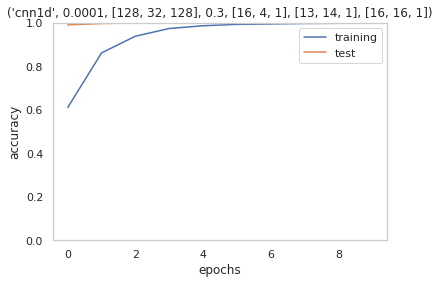

In [123]:
plot(1,train_acc,None,test_acc)

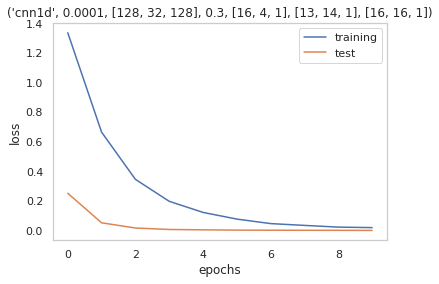

In [89]:
plot(0,train_loss,None,test_loss)

## Interpretation

In [102]:
c1=model.model[0](batch.to(device))
r1=model.model[1](c1)
c2=model.model[4](r1)
r2=model.model[5](c2)
c3=model.model[8](r2)
r3=model.model[9](c3)

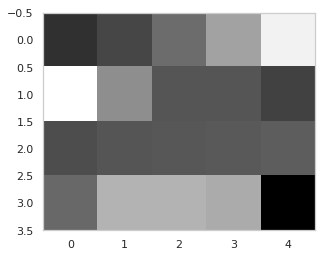

In [104]:
plt.imshow(test_set[-1].T,cmap="gray")

In [109]:
c1.detach().cpu().numpy()[-1:,:,:10].shape

(1, 128, 10)

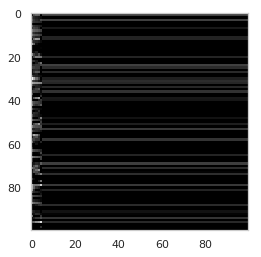

In [113]:
plt.imshow(r1.detach().cpu().numpy()[-1,:100,:100],cmap="gray")

#  Data exploration

In [10]:
max([stroke.shape[0] for stroke in words])

289

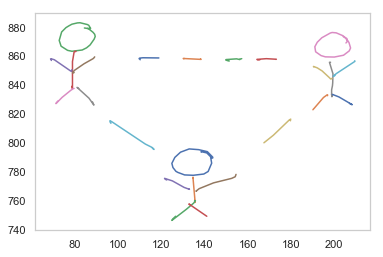

In [30]:
for j,i in enumerate(drawings[0]):
    plt.plot(i[:,0],i[:,1])

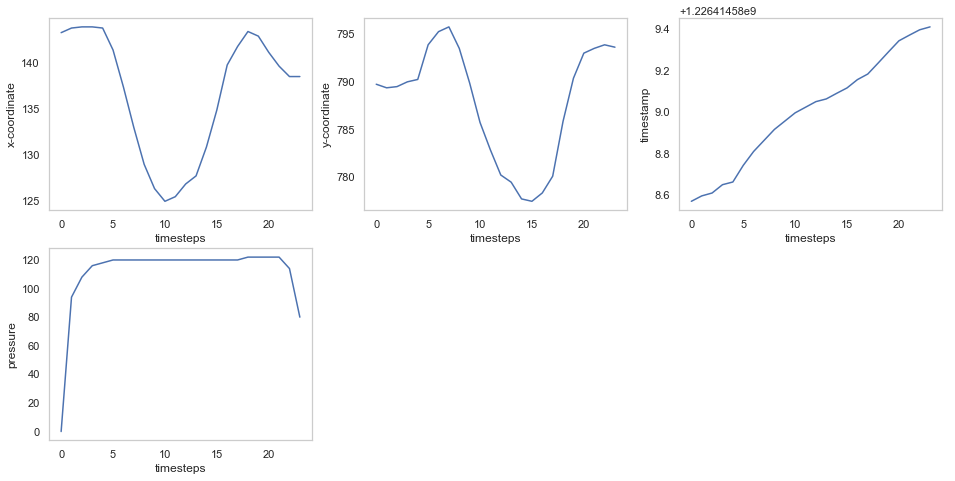

In [28]:
plot_measures(drawings[0][0])

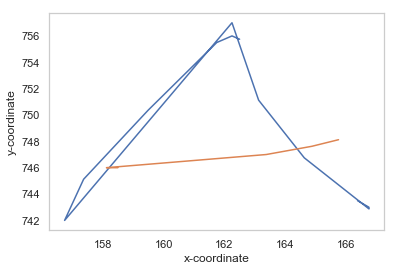

In [46]:
for s in words[0][1]:
    plot_task(s,measure2index)

# AE hyperparams

In [14]:
dropout=0.0
hidden_size=[16,32,64]  
conv_kernel= [8,4,3]
pool_kernel=[8,4,3]
assert (max_len/np.prod(pool_kernel))%1==0
dilation= 'redef as 1'#[1,1]
stride='redef as kernel_size'
output_size="foo"
padding=[0,0,0]
"""for d,k in list(zip(dilation,conv_kernel)):
    padding.append((k-1)//2)#d*(k-1)//2)"""
input_size=2
batch_size=64
loss_fn=torch.nn.MSELoss()

learning_rate=1e-3
verbose=False
model_type="CNNAutoencoder"

model_name=str((model_type,learning_rate,hidden_size, dropout, conv_kernel,pool_kernel,dilation))

# for a fully pytorch code (requires ~ 10 GB of RAM)
## Pad the dataset

In [9]:
test_words=pad_data(test_words,max_len)

test_drawings=pad_data(test_drawings,max_len)

In [109]:
train_words=pad_data(train_words)

train_drawings=pad_data(train_drawings)

## Create PyTorch dataset

In [ ]:
class IamonDoDataset(Dataset):
    def __init__(self, drawings, words):
        self.data=np.concatenate((drawings, words))
        self.targets=np.concatenate((np.zeros(drawings.shape[0]), np.ones(words.shape[0])))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        return self.data[idx],self.targets[idx]
    
test_set=IamonDoDataset(test_drawings, test_words)
train_set=IamonDoDataset(train_drawings, train_words)

In [ ]:

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [102]:
for i_batch, batch in enumerate(test_loader):
    batch_data, batch_targets=batch
    batch_data=batch_data.transpose(1,2).to(device)
    batch_targets=batch_targets.to(device)
    #print(i_batch, batch_data.shape,batch_targets.shape)
    

# keep for ref

In [2]:
foo=np.arange(8)#used this in pahaw to reverse the measures

keepmeasures=np.array([1,0,2,3])

foo[keepmeasures]

array([1, 0, 2, 3])